# Master Drifter Evaluation Notebook

***

In [29]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.io import loadmat
from salishsea_tools import viz_tools

%matplotlib inline

In [81]:
plt.rcParams['font.size'] = 14

***

### Skill score definition

[Liu and Weisberg 2011, JGR Oceans](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010JC006837)

$$\left. s = \sum_{i=1}^Nd_i \middle/ \sum_{i=1}^NI_{oi} \right.$$

In [34]:
def mtime2datetime(mtime):
    """Convert matlab time to python datetime object
    """
    
    pytime = datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)
    
    return pytime

In [65]:
# Paths, files and definitions
paths = {
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'drifters': '/ocean/shared/drifters/data/L3/Salish_L3_20190728T103529.mat',
    'out': '/data/bmoorema/results/parcels/drifters_base/',
}
grid = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
drifters = loadmat(paths['drifters'])['drift'][0]
IDs = [4, 32, 82, 106]
deg2m = 111000 * np.cos(50 * np.pi / 180)
duration = timedelta(days=5)

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


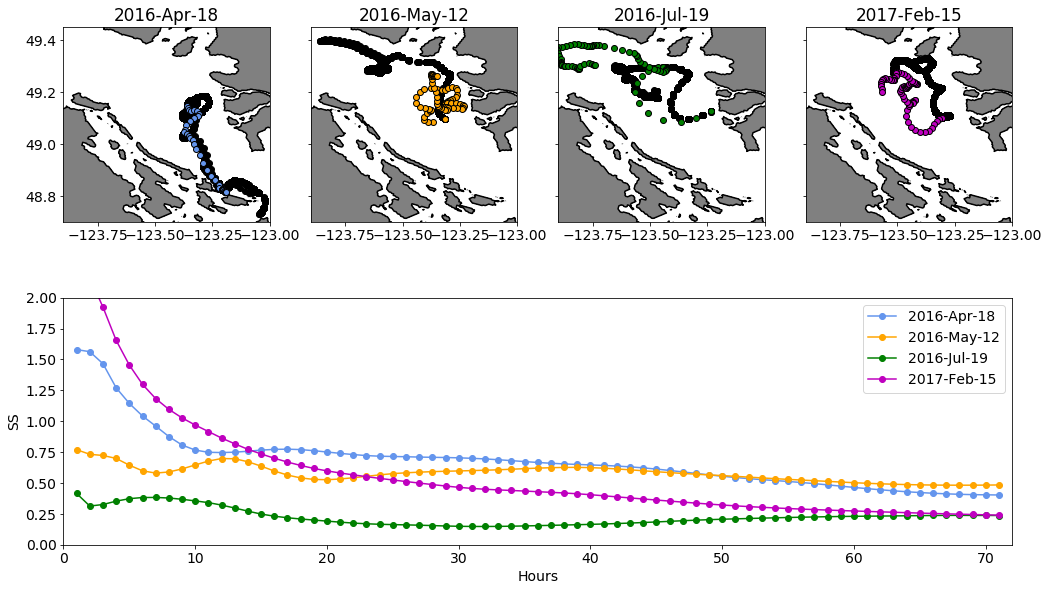

In [87]:
# Make figure
fig = plt.figure(figsize=(17, 10))
gs = plt.GridSpec(2, 4)
ax_ss = fig.add_subplot(gs[1, :])
ax_ss.set_xlim([0, 72])
ax_ss.set_ylim([0, 2])
ax_ss.set_xlabel('Hours')
ax_ss.set_ylabel('SS')

# Loop through simulations
for col, ID, color in zip(range(4), IDs, ['cornflowerblue', 'orange', 'g', 'm']):
    
    # Parse ID
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    t_obs = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex]])
    fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [t_obs[0], t_obs[0]+duration]) + '.nc'
    metrics = {'dl': np.empty(0), 'd': np.empty((0, 50))}
    label = t_obs[0].strftime('%Y-%b-%d')
    
    # Make map area
    ax = fig.add_subplot(gs[0, col])
    ax.contourf(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
    ax.contour(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([-123.9, -123.0])
    ax.set_ylim([48.7, 49.45])
    ax.set_title(label)
    viz_tools.set_aspect(ax)
    if col > 0: ax.yaxis.set_ticklabels('')

    # Load simulation
    with xr.open_dataset(paths['out'] + fn) as data:

        # Load and plot trajectories
        times = data.time[0, :].values.astype('datetime64[s]').astype(datetime)
        lons, lats = data.lon.values, data.lat.values
        
        # Loop through simulation time points
        index = 0
        for time, lon, lat in zip(times[:72], lons.T, lats.T):
            
            # Extract observations
            ilast = index
            index = abs(t_obs - time).argmin()
            lon_obs, lat_obs = drifters['lon'][dindex], drifters['lat'][dindex]
            ax.plot(lon, lat, 'ko', zorder=1)
            ax.plot(lon_obs[index], lat_obs[index], 'ko', markerfacecolor=color, zorder=2)

            # Calculate metrics
            d = np.sqrt((lon - lon_obs[index])**2 + (lat - lat_obs[index])**2) * deg2m * 1e-3
            dl = np.sqrt((lon_obs[index] - lon_obs[ilast])**2 + (lat_obs[index] - lat_obs[ilast])**2) * deg2m * 1e-3
            metrics['dl'] = np.append(metrics['dl'], dl)
            metrics['d'] = np.concatenate((metrics['d'], d[np.newaxis, :]))

    # Calc skill score
    ss = np.cumsum(metrics['d'], axis=0) / np.cumsum(np.cumsum(metrics['dl']))[:, np.newaxis]
    ax_ss.plot(ss.mean(axis=1), 'o-', color=color, label=label)
    
ax_ss.legend()